# PR1: Medical Text Classification

* Author: Kevin Chuang [@k-chuang](https://www.github.com/k-chuang)
* Created on: September 21, 2018
* Description: Given a medical abstract, classify condition of patient (5 classes) using K-Nearest Neighbors.

-----------

## Import libraries

In [1]:
__author__ = 'Kevin Chuang (https://www.github.com/k-chuang)' 

# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

# Text Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

# Natural Language Processing
from nltk import word_tokenize, WordNetLemmatizer

# Metrics
from sklearn.metrics import f1_score

# Utilities
import string
import math
from operator import itemgetter 
from collections import Counter, defaultdict
from scipy.sparse import csr_matrix
import scipy.sparse as sp

%matplotlib inline


sns.set(rc={"figure.figsize": (20.0, 10.0), "axes.labelsize": 14})

# sns.set_context("poster")

## Load data

In [2]:
train_df = pd.read_csv('train.dat', sep='\t', header=None, names=['Label', 'Abstract'])
test_df = pd.read_csv('test.dat', sep='\t', header=None, names=['Abstract'])
submission_df = pd.read_csv('format.dat', header=None, names=['Labels'])

In [3]:
train_df.head()

,Label,Abstract
0,4,Catheterization laboratory events and hospital...
1,5,Renal abscess in children. Three cases of rena...
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...
3,5,Subclavian artery to innominate vein fistula a...
4,4,Effect of local inhibition of gamma-aminobutyr...


In [4]:
test_df.head()

,Abstract
0,Excision of limbal dermoids. We reviewed the c...
1,Bell's palsy. A diagnosis of exclusion. In cas...
2,Retained endobronchial foreign body removal fa...
3,Recurrent buccal space abscesses: a complicati...
4,Intracranial fibromatosis. Fibromatoses are un...


## Data Exploration

- View a sample of the medical abstract text
- Read through it, and I definitely had to Google some terminology
    - Initial observations of medical abstract text
        - There are a lot of complex medical terms (e.g. acute myocardial infarction) 
        - There seems to be a lot of n = some integer (e.g. n = 100)
        - There seems to be a lot of percentages (e.g. 55%)

In [5]:
# Check for null abstracts
train_df.Abstract.isnull().sum()

0

In [6]:
train_df['Abstract'][0]

'Catheterization laboratory events and hospital outcome with direct angioplasty for acute myocardial infarction To assess the safety of direct infarct angioplasty without antecedent thrombolytic therapy, catheterization laboratory and hospital events were assessed in consecutively treated patients with infarctions involving the left anterior descending (n = 100 patients), right (n = 100), and circumflex (n = 50) coronary arteries. The groups of patients were similar for age (left anterior descending coronary artery, 59 years; right coronary artery, 58 years; circumflex coronary artery, 62 years), patients with multivessel disease (left anterior descending coronary artery, 55%; right coronary artery, 55%; circumflex coronary artery, 64%), and patients with initial grade 0/1 antegrade flow (left anterior descending coronary artery, 79%; right coronary artery, 84%; circumflex coronary artery, 90%). Cardiogenic shock was present in eight patients with infarction of the left anterior descen

In [7]:
train_df['Abstract'][1]

'Renal abscess in children. Three cases of renal abscesses in children are described to illustrate the variable presenting features. An additional 23 pediatric cases, reported over the past ten years, were reviewed for clinical features and therapy. Fever, loin pain, and leukocytosis were common presenting features, but less than half of all abscesses were associated with either an abnormal urinalysis or a positive urine culture. The presenting features were sometimes confused with appendicitis, peritonitis, or a Wilms tumor. An organism was identified in 17 cases--Escherichia coli in 9 children and Staphylococcus aureus in 8 children. The majority of E. coli infections occurred in girls and the majority of S. aureus infections occurred in boys. Reflux was documented in 5 patients, and 2 children had a possible extrarenal source of infection. Antibiotics alone produced a cure in 10 children (38%), but 16 children (62%) required a surgical procedure. '

In [8]:
# Imbalanced classes

train_df['Label'].value_counts()

5    4805
1    3163
4    3051
3    1925
2    1494
Name: Label, dtype: int64

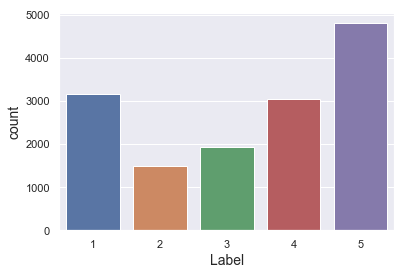

In [9]:
sns.countplot(x='Label', data=train_df)

## Data Preprocessing

- I am going to use Bag of Words for text preprocessing
- BOW basically breaks up the note into the individual words and counts how many times each word occurs.
- I  remove some of the unimportant words such as 'the', 'to',
- I will use a tokenizer and a vectorizer. 
    - The tokenizer breaks a single abstract into a list of words and a vectorizer takes a list of words and counts the words.
- `Tokenizer`:
    - Remove punctuation & numbers
    - Lowercase everything
    - Lemmatize all the text (e.g. women will become woman)
        - Goal is reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.
        - Lemmatization is the process of converting the words of a sentence to its dictionary form. 
- `Vectorizer`:
    - `CountVectorizer`
        - Encodes a vector with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.
        - vocabulary_ is a dict/mapping of the terms to their indices in the document-term matrix, not the counts.
    - `TfidfVectorizer`
        - Convert a collection of raw documents to a matrix of TF-IDF features.
        - TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.
        - Term frequency-inverse document frequency is a statistic that reflects how important a word is to a specific document relative to all of the words in a collection of documents (the corpus).

In [10]:
def tokenizer(text):
    '''Tokenize text into a list of preprocessed words '''
    
    # Create a string with all punctuations & digits concatenated
    num_and_punc = string.punctuation + string.digits
    
    # Create a mapping to space using string above for each num/punc & return a translation table with mapping
    t_table = str.maketrans(dict.fromkeys(num_and_punc, " "))
    
    # Lower text and use translation table to remove all punctuation and digits
    text = text.lower().translate(t_table)
    
    # Use Lemma tokenizer to tokenize the words
    lemma = WordNetLemmatizer()
    lemmas = [lemma.lemmatize(word.strip()) for word in text.split()]
    
#     Remove one letter words
#     lemmas = [x for x in lemmas if len(x) > 1]
    return lemmas
#     tokens = word_tokenize(text)
#     tokens = [x for x in tokens if len(x) > 1]
#     return tokens

In [11]:
print(tokenizer(train_df['Abstract'][1]))

['renal', 'abscess', 'in', 'child', 'three', 'case', 'of', 'renal', 'abscess', 'in', 'child', 'are', 'described', 'to', 'illustrate', 'the', 'variable', 'presenting', 'feature', 'an', 'additional', 'pediatric', 'case', 'reported', 'over', 'the', 'past', 'ten', 'year', 'were', 'reviewed', 'for', 'clinical', 'feature', 'and', 'therapy', 'fever', 'loin', 'pain', 'and', 'leukocytosis', 'were', 'common', 'presenting', 'feature', 'but', 'le', 'than', 'half', 'of', 'all', 'abscess', 'were', 'associated', 'with', 'either', 'an', 'abnormal', 'urinalysis', 'or', 'a', 'positive', 'urine', 'culture', 'the', 'presenting', 'feature', 'were', 'sometimes', 'confused', 'with', 'appendicitis', 'peritonitis', 'or', 'a', 'wilms', 'tumor', 'an', 'organism', 'wa', 'identified', 'in', 'case', 'escherichia', 'coli', 'in', 'child', 'and', 'staphylococcus', 'aureus', 'in', 'child', 'the', 'majority', 'of', 'e', 'coli', 'infection', 'occurred', 'in', 'girl', 'and', 'the', 'majority', 'of', 's', 'aureus', 'infect

In [12]:
vec = CountVectorizer(tokenizer = tokenizer)
vec.fit(train_df['Abstract'])
X_train = vec.transform(train_df['Abstract'])
# abstract_df = vec.fit_transform(train_df['Abstract'])

In [13]:
# print(vec.vocabulary_)

In [14]:
# Size is around 31869 unique words

len(vec.vocabulary_)

31869

In [15]:
vocab_names = vec.get_feature_names()

In [16]:
word_counts = np.asarray(X_train.sum(axis=0))

In [17]:
vocab_counts_df = pd.DataFrame.from_dict({'Word':vocab_names, 'Counts':word_counts.ravel()})


In [18]:
vocab_counts_df.head()

,Word,Counts
0,a,53609
1,aa,28
2,aaa,27
3,aab,7
4,aaem,3


In [19]:
vocab_counts_df.sort_values(['Counts'], ascending=False).head(60)

,Word,Counts
28816,the,122496
20126,of,121285
1207,and,81967
13780,in,79415
0,a,53609
31599,with,43935
29150,to,43083
21260,patient,39336
31321,wa,28458
31488,were,24358


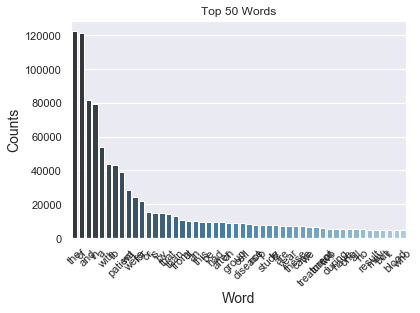

In [20]:
# Let's plot the top 50 most frequently occurring words
top50 = vocab_counts_df.sort_values(['Counts'], ascending=False).iloc[:50]

ax = sns.barplot("Word", "Counts", data=top50, palette="Blues_d");
ax.set_title('Top 50 Words')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

### Stop words

- Stop words are words we do not want to use as features, and shall remove from our training
- These include words like `the` or `and` or `a` that are not very important
    - We will also use the English stop words form the standard sklearn package
- Fit new `CountVectorizer` with these stop words removed

In [21]:
# Let's create our own stop words list & remove unimportant words such as 'the' or 'and'
# Also, let's use the sklearn ENGLISH_STOP_WORDS, and unionize these to create the last stop words list

my_stop_words = ['the', 'of', 'and', 'in', 'a', 'with', 'to', 
              'were', 'wa', 'for', 'or', 'is', 'by', 'that', 
              'than', 'from', 'at', 'an', 'this', 'be', 'had'
             'after', 'on', 'p', 'are', 'these', 'we', 'have', 'may', 
              'it', 'who', 'pm', 'am', 'patient', 's', 'aa', 'll', 're', 'date',
              'as', 'o', 'wa']

stop_words = ENGLISH_STOP_WORDS.union(my_stop_words)

In [22]:
# 322 stop words
len(stop_words)

328

In [ ]:
count_vec = CountVectorizer(tokenizer = tokenizer, 
                       stop_words = stop_words)
count_vec.fit(train_df['Abstract'])

In [ ]:
X_train_count = count_vec.transform(train_df['Abstract'].values)
X_test_count = count_vec.transform(train_df['Abstract'].values)

In [23]:
# Using idf
# tfidf_vec = TfidfVectorizer(tokenizer = tokenizer, norm='l2', ngram_range=(1,3), max_df = 0.4,
#                        stop_words = stop_words, use_idf=True)
tfidf_vec = TfidfVectorizer(tokenizer = tokenizer, norm='l2', ngram_range=(1,2), stop_words = stop_words)
tfidf_vec.fit(train_df['Abstract'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=frozenset({'more', 'become', 'system', 'hereby', 'twenty', 'p', 'go', 'became', 'onto', 'must', 'over', 'how', 'also', 'after', 'everywhere', 'him', 'next', 'whom', 'our', 'hadafter', 'seems', 'three', 'whose', 'nor', 'about', 'now', 'front', 'ten', 'himself', 'on', 'seemed', 'being', 'mo..., 'top', 'serious', 'call', 'last', 'nowhere', 'hers', 'is', 'first', 'wherein', 'somewhere', 'we'}),
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizer at 0x12091dae8>, use_idf=True,
        vocabulary=None)

In [24]:
X_train_tfidf = tfidf_vec.transform(train_df['Abstract'].values)
X_test_tfidf = tfidf_vec.transform(train_df['Abstract'].values)

In [25]:
X_train_tfidf.shape

(14438, 661860)

In [26]:
# X_train_tfidf[0].toarray()

In [27]:
# # Just to check
# tfidf_vec.inverse_transform(X_train_tfidf[1].toarray())

In [28]:
Y_train = train_df['Label'].values

In [29]:
Y_train[0]

4

In [ ]:
# # adding "features" columns as SparseSeries
# for i, col in enumerate(tfidf_vec.get_feature_names()):
#     train_df[col] = pd.SparseSeries(X_train_tfidf[:, i].toarray().ravel(), fill_value=0)
#     test_df[col] = pd.SparseSeries(X_test_tfidf[:, i].toarray().ravel(), fill_value=0)

In [ ]:
# train_df.drop('Abstract', axis=1, inplace=True)
# test_df.drop('Abstract', axis=1, inplace=True)

## Implement k-NN classifier

- KNN is a lazy, nonparametric, instance based classifier 
- Let's first define some standard distance / similiarity metrics (We will use the sklearn implementation)
    - Euclidean
    - Jaccard
        - Good when text is lemmatized and CountVectorizer is used
        - Number of words that appear in a document are weighted the same and have no effect on this metric
    - Cosine
        - Good when using bag of words with tf-idf
        - Have to normalize vectors when using cosine similarity
    - Hamming distance
        - Good for text classification
    - Levenhstein distance

In [37]:
def csr_l2normalize(mat, copy=False):
    r""" Normalize the rows of a CSR matrix by their L-2 norm.
    If copy is True, returns a copy of the normalized matrix.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # normalize
    for i in range(nrows):
        rsum = 0.0
        for j in range(ptr[i], ptr[i+1]):
            rsum += val[j]**2
        if rsum == 0.0:
            continue # do not normalize empty rows
        rsum = 1.0/np.sqrt(rsum)
        for j in range(ptr[i], ptr[i+1]):
            val[j] *= rsum

    if copy is True:
        return mat

In [38]:
import math

def euclidean_distance(i1, i2):
    '''Calcualte Euclidean distance of two vectors'''
    distance = math.sqrt(sum(pow(a-b, 2) for a, b in zip(i1, i2)))
    return distance

def two_norm(x): 
    '''Calculates the two norm of a vector'''
    return math.sqrt(sum([a*a for a in x]))

def cosine_distance(i1, i2):
    '''Calculate cosine distance of two vectors'''
    # Calculate dot product
    numerator = sum(a*b for a,b in zip(i1,i2))
    # Calculate norm of each instance
    denominator = two_norm(i1)*two_norm(i2)
    cos_dist = 1.0 - float(numerator)/float(denominator)
    return cos_dist

def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

def two_norm_sparse(x): 
    '''Calculates the two norm of a sparse matrix'''
#     two_norm = np.sqrt(x.multiply(x).sum(1))
    two_norm = np.sqrt(x.multiply(x).sum(1))
#     print(two_norm)
    return two_norm
    

def cosine_similarity_sparse(s1, s2):
    '''Calculate cosine similiarity of two sparse matrices'''
    # Calculate dot product
    numerator = s1.dot(s2.T)
    # Calculate norm of each instance
#     denominator = two_norm_sparse(s1) * (two_norm_sparse(s2))
#     print(denominator)
    return numerator
#     return numerator/denominator

def cosine_distance_sparse(s1, s2):
    '''Calculate cosine distance of two sparse matrices'''
    # Calculate dot product
    numerator = s1.dot(s2.T)
    if s1.shape[0] > s2.shape[0]:
        one_array = np.ones((s1.shape[0], 1), dtype=float)
    else:
        one_array = np.ones((s2.shape[0], 1), dtype=float)
    # Calculate norm of each instance
    denominator = two_norm_sparse(s1) * (two_norm_sparse(s2))
#     print(denominator)
    return csr_matrix(one_array - (numerator/denominator))
#     return numerator/denominator

def euclidean_distance_sparse(s1, s2):
    '''Calcualte Euclidean distance of two sparse matrices'''
    
    i1 = s1.toarray()
    i2 = s2.toarray()
    d = csr_matrix(i1 - i2)
    d = two_norm_sparse(d)
#     d = np.sqrt(np.sum(np.power(i1 - i2, 2), axis=1, keepdims=True))
    return csr_matrix(d)

In [39]:
# from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity

In [41]:
from scipy.spatial.distance import cdist

In [ ]:
# euclidean_distance_sparse(X_train_tfidf[0:30], X_train_tfidf[50])

In [ ]:
# cdist(X_train_tfidf[0:30].toarray(), X_train_tfidf[50].toarray(), 'euclidean')
# cdist(X_train_tfidf[0:30].toarray(), X_train_tfidf[50].toarray(), 'cosine')
# cdist(X_train_tfidf[0:30].toarray(), X_train_tfidf[50].toarray(), 'jaccard')
# cdist(X_train_tfidf[0:30].toarray(), X_train_tfidf[50].toarray(), 'hamming')
# cdist(X_train_tfidf[0:30].toarray(), X_train_tfidf[50].toarray(), 'mahalanobis', VI=None)
# cdist(X_train_tfidf[0:30].toarray(), X_train_tfidf[50].toarray(), 'chebyshev')


In [ ]:
# euclidean_distance_sparse(X_train_tfidf[0:30], X_train_tfidf[50]).toarray()

In [ ]:
# cosine_distance_sparse(X_train_tfidf[0:30], X_train_tfidf[50]).toarray()

In [42]:
def classify_condition(train, labels, instance, K=5, metric = 'cosine'):
    '''Using a distance metric to classify an instance'''
    if metric == 'cosine':
#         dots = cosine_similarity_sparse(instance, train)
        dots = cosine_distance_sparse(train, instance)
#         reverse = True
    elif metric == 'euclidean':
        dots = euclidean_distance_sparse(train, instance)
#         dots = csr_matrix(euclidean_distances(train.toarray(), instance.toarray()))
#         dots = csr_matrix(cdist(train.toarray(), instance.toarray(), 'euclidean'))
#         reverse = False
    # Edit below later on
    elif metric == 'jaccard':
        dots = csr_matrix(cdist(train.toarray(), instance.toarray(), 'jaccard'))
    else:
        dots = cosine_distance_sparse(train, instance)
        
        
#     print(dots.indptr)
    neighbors = list(zip(dots.indptr, dots.data))
    if len(neighbors) == 0:
        # could not find any neighbors
        print('Could not find any neighbors.... Choosing a random one')
        return np.asscalar(np.random.randint(low=1, high=5, size=1))
    neighbors.sort(key=lambda x: x[1], reverse=False)

#     print(neighbors[:K])
    tc = Counter(labels[s[0]] for s in neighbors[:K]).most_common(5)
#     print(tc)
    if len(tc) < 5 or tc[0][1] > tc[1][1]:
        # majority vote
        return tc[0][0]
    # tie break
    tc = defaultdict(float)
    for s in neighbors[:K]:
        tc[labels[s[0]]] += s[1]
#     print(tc)
    return sorted(tc.items(), key=lambda x: x[1], reverse=True)[0][0]

In [43]:
def split_data(features, labels, fold_num = 1, fold=10):
    n = features.shape[0]
    fold_size = int(np.ceil(n*1.0/fold))
    feats = []
    cls_train = []
    for f in range(fold):
        if f+1 != fold_num:
            feats.append(features[f*fold_size: min((f+1)*fold_size, n)])
            cls_train.extend(labels[f*fold_size: min((f+1)*fold_size, n)])
    # join all fold matrices that are not the test matrix
    train = sp.vstack(feats, format='csr')
    # extract the test matrix and class values associated with the test rows
    test = features[(fold_num-1)*fold_size: min(fold_num*fold_size, n), :]
    cls_test = labels[(fold_num-1)*fold_size: min(fold_num*fold_size, n)]
    return train, cls_train, test, cls_test

In [44]:
def evaluate_model(features, labels, metric='cosine', K=3, fold=10):
    '''Using KFold Cross Validation to evaluate model accuracy'''
    if metric not in ['cosine', 'euclidean', 'jaccard', 'hamming', 'mahalanobis']:
        raise ValueError('Metric must be `cosine`, `euclidean`, or `jaccard`')
    
    macc = 0.0
    cum_f1 = 0.0
#     features = csr_l2normalize(features, copy=True)
    for f in range(fold):
        # split data into training and testing
        train_set, train_labels, test_set, test_labels = split_data(features, labels, f+1, fold)
        # predict the class of each test sample
        predictions = [classify_condition(train_set, train_labels, test_set[i,:], K=K, metric=metric) 
                       for i in range(test_set.shape[0])]
#         for i in range(test_set.shape[0]):
#             neighbors = nearest_neighbors(train_set, train_labels, test_set[i, :], K = K)
#             predictions = [classify(train_labels, neighbors) for i in range(test.shape[0]) ]
#         print(test_labels)
        # compute the accuracy of the prediction
        acc = 0.0
        for i in range(len(test_labels)):
            if test_labels[i] == predictions[i]:
                acc += 1
        acc /= len(test_labels)
        f1 = f1_score(test_labels, predictions, average='weighted')
#         print('Fold-%i Accuracy: %.05f' % (f+1, acc))
        print('Fold-%i F1 Score: %.05f' % (f+1, f1))
        macc += acc
        cum_f1 += f1
    
    return macc/float(fold), cum_f1/float(fold)
        

In [46]:
a, f = evaluate_model(X_train_tfidf, Y_train, metric = 'cosine', K=42, fold=10)

f

Fold-1 F1 Score: 0.60300
Fold-2 F1 Score: 0.59791
Fold-3 F1 Score: 0.63220
Fold-4 F1 Score: 0.61925
Fold-5 F1 Score: 0.58172
Fold-6 F1 Score: 0.60622
Fold-7 F1 Score: 0.60755
Fold-8 F1 Score: 0.60413
Fold-9 F1 Score: 0.62200
Fold-10 F1 Score: 0.59989


0.6073875400440121

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=5)

scores = cross_val_score(knn, X_train_tfidf, Y_train, cv=10, scoring='f1_weighted', n_jobs=3)

In [ ]:
print(scores)
scores.mean()

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

k_grid = np.arange(1, 140, 10)
param_grid = {'n_neighbors': k_grid}

clf = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10, scoring='f1_weighted', n_jobs=3, verbose=3)

In [31]:
clf.fit(X_train_tfidf, Y_train)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] .......... n_neighbors=1, score=0.3805840630673704, total=   1.3s
[CV] .......... n_neighbors=1, score=0.3827546597713373, total=   1.3s
[CV] n_neighbors=1 ...................................................
[CV] ......... n_neighbors=1, score=0.35192318911214887, total=   1.4s
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] ......... n_neighbors=1, score=0.39803480270008823, total=   1.2s
[CV] n_neighbors=1 ...................................................
[CV] ......... n_neighbors=1, score=0.37187592389598884, total=   1.2s
[CV] n_neighbors=1 ...................................................
[CV] .........

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.8min


[CV] ......... n_neighbors=21, score=0.5987692515985877, total=   1.2s
[CV] n_neighbors=21 ..................................................
[CV] ......... n_neighbors=21, score=0.5852399636106745, total=   1.1s
[CV] n_neighbors=31 ..................................................
[CV] ......... n_neighbors=21, score=0.6115427005705056, total=   1.1s
[CV] n_neighbors=31 ..................................................
[CV] ........... n_neighbors=21, score=0.59409452109336, total=   1.1s
[CV] n_neighbors=31 ..................................................
[CV] ......... n_neighbors=31, score=0.5928058884997991, total=   1.2s
[CV] n_neighbors=31 ..................................................
[CV] .......... n_neighbors=31, score=0.592360105808841, total=   1.1s
[CV] n_neighbors=31 ..................................................
[CV] ......... n_neighbors=31, score=0.6194582687572691, total=   1.2s
[CV] n_neighbors=31 ..................................................
[CV] .

[CV] ......... n_neighbors=81, score=0.5935893652529867, total=   1.6s
[CV] n_neighbors=81 ..................................................
[CV] ......... n_neighbors=81, score=0.5974027620593263, total=   1.3s
[CV] n_neighbors=81 ..................................................
[CV] ......... n_neighbors=81, score=0.6052609385970358, total=   1.3s
[CV] n_neighbors=81 ..................................................
[CV] ......... n_neighbors=81, score=0.6120017594871892, total=   1.5s
[CV] n_neighbors=91 ..................................................
[CV] ......... n_neighbors=81, score=0.6168292154088842, total=   1.4s
[CV] n_neighbors=91 ..................................................
[CV] .......... n_neighbors=81, score=0.589766799573471, total=   1.2s
[CV] n_neighbors=91 ..................................................
[CV] ......... n_neighbors=91, score=0.6015067993662244, total=   1.4s
[CV] n_neighbors=91 ..................................................
[CV] .

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  7.6min


[CV] ........ n_neighbors=121, score=0.6208993752989813, total=   1.2s
[CV] n_neighbors=121 .................................................
[CV] ........ n_neighbors=121, score=0.6098443556450129, total=   1.4s
[CV] n_neighbors=121 .................................................
[CV] ........ n_neighbors=121, score=0.5828201516247669, total=   1.2s
[CV] n_neighbors=121 .................................................
[CV] ........ n_neighbors=121, score=0.5925847316255005, total=   1.2s
[CV] n_neighbors=121 .................................................
[CV] ........ n_neighbors=121, score=0.5974280853775459, total=   1.3s
[CV] n_neighbors=121 .................................................
[CV] ........ n_neighbors=121, score=0.6008974765646465, total=   1.2s
[CV] n_neighbors=131 .................................................
[CV] ........ n_neighbors=121, score=0.6229661028074461, total=   1.2s
[CV] n_neighbors=131 .................................................
[CV] .

[Parallel(n_jobs=3)]: Done 140 out of 140 | elapsed:  8.7min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'n_neighbors': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=3)

In [32]:
clf.best_params_

{'n_neighbors': 51}

In [33]:
k_grid = np.arange(40, 60, 1)
param_grid = {'n_neighbors': k_grid}

clf = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10, scoring='f1_weighted', n_jobs=3, verbose=3)

In [34]:
clf.fit(X_train_tfidf, Y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] n_neighbors=40 ..................................................
[CV] n_neighbors=40 ..................................................
[CV] n_neighbors=40 ..................................................
[CV] ......... n_neighbors=40, score=0.5922019905671804, total=   1.4s
[CV] n_neighbors=40 ..................................................
[CV] .......... n_neighbors=40, score=0.628508064135783, total=   1.4s
[CV] n_neighbors=40 ..................................................
[CV] ......... n_neighbors=40, score=0.5959713300739028, total=   1.4s
[CV] n_neighbors=40 ..................................................
[CV] ......... n_neighbors=40, score=0.6188222145118719, total=   1.4s
[CV] n_neighbors=40 ..................................................
[CV] ......... n_neighbors=40, score=0.5873770416539499, total=   1.3s
[CV] n_neighbors=40 ..................................................
[CV] .........

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.9min


[CV] .......... n_neighbors=42, score=0.606406714330781, total=   1.4s
[CV] n_neighbors=43 ..................................................
[CV] .......... n_neighbors=42, score=0.600396127738642, total=   1.3s
[CV] n_neighbors=43 ..................................................
[CV] ......... n_neighbors=42, score=0.6263096743762426, total=   1.3s
[CV] n_neighbors=43 ..................................................
[CV] ......... n_neighbors=43, score=0.5924147505449702, total=   1.3s
[CV] n_neighbors=43 ..................................................
[CV] ......... n_neighbors=43, score=0.6006151607541685, total=   1.3s
[CV] n_neighbors=43 ..................................................
[CV] ......... n_neighbors=43, score=0.6223960907274739, total=   1.2s
[CV] n_neighbors=43 ..................................................
[CV] ......... n_neighbors=43, score=0.6141888742604622, total=   1.3s
[CV] n_neighbors=43 ..................................................
[CV] .

[CV] ......... n_neighbors=48, score=0.6010389622851747, total=   1.2s
[CV] n_neighbors=48 ..................................................
[CV] ......... n_neighbors=48, score=0.6070944913670104, total=   1.2s
[CV] n_neighbors=48 ..................................................
[CV] .......... n_neighbors=48, score=0.598089094162048, total=   1.2s
[CV] n_neighbors=49 ..................................................
[CV] ......... n_neighbors=48, score=0.6197007808974869, total=   1.2s
[CV] n_neighbors=49 ..................................................
[CV] ......... n_neighbors=48, score=0.6041329906583174, total=   1.2s
[CV] n_neighbors=49 ..................................................
[CV] ......... n_neighbors=49, score=0.6039311271776224, total=   1.1s
[CV] n_neighbors=49 ..................................................
[CV] .......... n_neighbors=49, score=0.600699925421494, total=   1.2s
[CV] n_neighbors=49 ..................................................
[CV] .

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  7.6min


[CV] ......... n_neighbors=52, score=0.6181830867219213, total=   1.2s
[CV] n_neighbors=52 ..................................................
[CV] ......... n_neighbors=52, score=0.6229241169894809, total=   1.3s
[CV] n_neighbors=52 ..................................................
[CV] ......... n_neighbors=52, score=0.5909659583658198, total=   1.2s
[CV] n_neighbors=52 ..................................................
[CV] ......... n_neighbors=52, score=0.6004539793614939, total=   1.2s
[CV] n_neighbors=52 ..................................................
[CV] ......... n_neighbors=52, score=0.6078832836361808, total=   1.2s
[CV] n_neighbors=52 ..................................................
[CV] .......... n_neighbors=52, score=0.593489099504249, total=   1.1s
[CV] n_neighbors=53 ..................................................
[CV] .......... n_neighbors=52, score=0.619061863681087, total=   1.2s
[CV] n_neighbors=53 ..................................................
[CV] .

[CV] ......... n_neighbors=58, score=0.6049634457778313, total=   1.3s
[CV] n_neighbors=58 ..................................................
[CV] ......... n_neighbors=58, score=0.6071252627868733, total=   1.1s
[CV] n_neighbors=58 ..................................................
[CV] ......... n_neighbors=58, score=0.6263632396905706, total=   1.2s
[CV] n_neighbors=58 ..................................................
[CV] ......... n_neighbors=58, score=0.6236717724533882, total=   1.3s
[CV] n_neighbors=58 ..................................................
[CV] ......... n_neighbors=58, score=0.5900733971972225, total=   1.1s
[CV] n_neighbors=58 ..................................................
[CV] ......... n_neighbors=58, score=0.6023080515754863, total=   1.2s
[CV] n_neighbors=58 ..................................................
[CV] ......... n_neighbors=58, score=0.6016348237884225, total=   1.2s
[CV] n_neighbors=58 ..................................................
[CV] .

[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed: 12.1min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'n_neighbors': array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=3)

In [35]:
clf.best_params_

{'n_neighbors': 42}

In [40]:
clf.best_score_

0.6077950723422624

In [ ]:
best_f1 = 0.0
best_k = None
best_acc = 0.0

# sqrt(# of training records) ~ 140  
for k in np.arange(1, 140, 5):
    acc, f1 = evaluate_model(X_train_tfidf, Y_train, K=k, fold=10)
#     print('For %i-NN, 10-Fold CV Average Accuracy: %.05f%%' % (k, acc * 100.0)) 
    print('For %i-NN, 10-Fold CV Weighted F1 Score: %.05f' % (k, f1)) 
    if f1 > best_f1:
        best_f1 = f1
        best_acc = acc
        best_k = k
    
print('Best Model Params: \n For %i-NN, 10-Fold CV Weighted F1 Score: %.08f' (best_k, best_f1))